In [ ]:
!pip install cleverhans

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
!pip install split-folders

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from sklearn.model_selection import train_test_split
import splitfolders
import numpy as np



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
splitfolders.ratio("/content/drive/MyDrive/Brain Tumor Classification/Brain_Tumor",
                   output="/content/drive/MyDrive/Brain Tumor Classification/Brain_Tumor_split",
                   seed=7,
                   ratio=(0.80, 0.05, 0.15))

Copying files: 7041 files [04:31, 25.93 files/s]


**New code with projected gradient descent**

In [ ]:
# Define the model
def build_model():
    Model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        # Recurrent layers (LSTM)
        layers.Reshape((8, 2304)),  # Adjust the shape for LSTM input
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(64),
        # Fully connected layers
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation="softmax")
    ])
    return Model

# Define adversarial example generation function
def generate_adversarial_examples(Model, images, labels, eps=0.05, eps_iter=0.01, nb_iter=35):
    # Gradient descent with projection onto epsilon ball
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    for _ in range(nb_iter):
        with tf.GradientTape() as tape:
            tape.watch(images)
            logits = Model(images)
            loss = loss_object(labels, logits)
        gradients = tape.gradient(loss, images)
        signed_grad = tf.sign(gradients)
        perturbation = eps_iter * signed_grad
        # Add perturbation while ensuring the resulting image remains in the valid range [0, 1]
        images = tf.clip_by_value(images + perturbation, 0, 1)
    return images


# Data generators
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Brain Tumor Classification/Brain_Tumor_split/train",
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/Brain Tumor Classification/Brain_Tumor_split/val",
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/Brain Tumor Classification/Brain_Tumor_split/test",
    target_size=(224, 224),
    batch_size=100,
    class_mode='categorical'
)

# Build and compile the model
Model = build_model()
Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])






Found 5631 images belonging to 4 classes.
Found 350 images belonging to 4 classes.
Found 1060 images belonging to 4 classes.


In [ ]:
# Generate adversarial examples using validation data
x_train, y_train = next(train_generator)
x_train_tensor = tf.convert_to_tensor(x_train)  # Convert to TensorFlow tensor
adv_images = generate_adversarial_examples(Model, x_train_tensor, y_train)

# Convert tensors to numpy arrays
adv_images_np = adv_images.numpy()

# Split adversarial examples into train and test parts
x_train_adv, x_test_adv, y_train_adv, y_test_adv = train_test_split(adv_images_np, y_train, test_size=0.3, random_state=42)

# Train the model with adversarial examples
print("Train with advarsarial data:")
history=Model.fit(x_train_adv, y_train_adv, epochs=50, validation_data=(x_test_adv, y_test_adv))





Train with advarsarial data:
Epoch 1/50
3/3 [==============================] - 6s 450ms/step - loss: 1.4656 - accuracy: 0.0429 - val_loss: 1.4000 - val_accuracy: 0.3333
Epoch 2/50
3/3 [==============================] - 0s 87ms/step - loss: 1.3789 - accuracy: 0.3857 - val_loss: 1.3875 - val_accuracy: 0.3333
Epoch 3/50
3/3 [==============================] - 0s 58ms/step - loss: 1.3671 - accuracy: 0.3857 - val_loss: 1.3723 - val_accuracy: 0.3333
Epoch 4/50
3/3 [==============================] - 0s 58ms/step - loss: 1.3594 - accuracy: 0.3857 - val_loss: 1.3703 - val_accuracy: 0.3333
Epoch 5/50
3/3 [==============================] - 0s 75ms/step - loss: 1.3481 - accuracy: 0.3857 - val_loss: 1.3832 - val_accuracy: 0.3333
Epoch 6/50
3/3 [==============================] - 0s 56ms/step - loss: 1.3328 - accuracy: 0.3857 - val_loss: 1.3644 - val_accuracy: 0.3333
Epoch 7/50
3/3 [==============================] - 0s 76ms/step - loss: 1.3211 - accuracy: 0.3857 - val_loss: 1.3479 - val_accuracy: 0.33

In [ ]:
predictions=Model.predict(x_test_adv)

1/1 [==============================] - 1s 659ms/step


In [ ]:
diseases_labels=[]

In [ ]:
for key, value in train_generator.class_indices.items():
  diseases_labels.append(key)

print(diseases_labels)


['glioma', 'meningioma', 'notumor', 'pituitary']


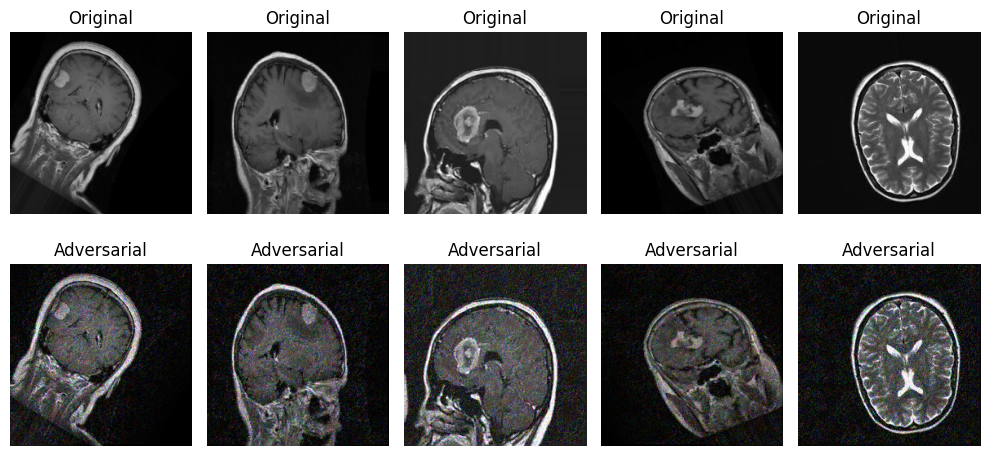

In [ ]:
# Adversarial Examples Visualization
import matplotlib.pyplot as plt

# Visualize original and adversarial examples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images_np[i])
    plt.title('Adversarial')
    plt.axis('off')

plt.tight_layout()
plt.show()


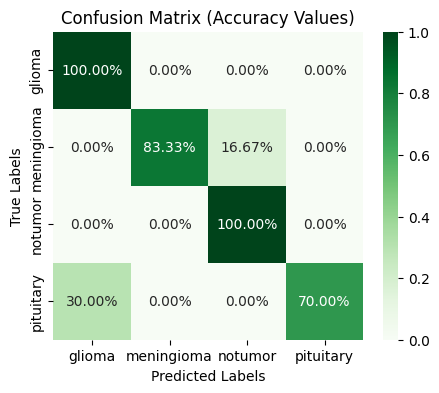

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict labels for adversarial test data
y_pred_adv_labels = np.argmax(predictions, axis=1)
y_true_labels = np.argmax(y_test_adv, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_adv_labels)
accuracy_values = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

plt.figure(figsize=(5, 4))
sns.heatmap(accuracy_values, annot=True, fmt=".2%", cmap="Greens", xticklabels=diseases_labels, yticklabels=diseases_labels)
plt.title("Confusion Matrix (Accuracy Values)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


<ipython-input-73-3a5aeb73efff>:10: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax[i].legend('train','val')


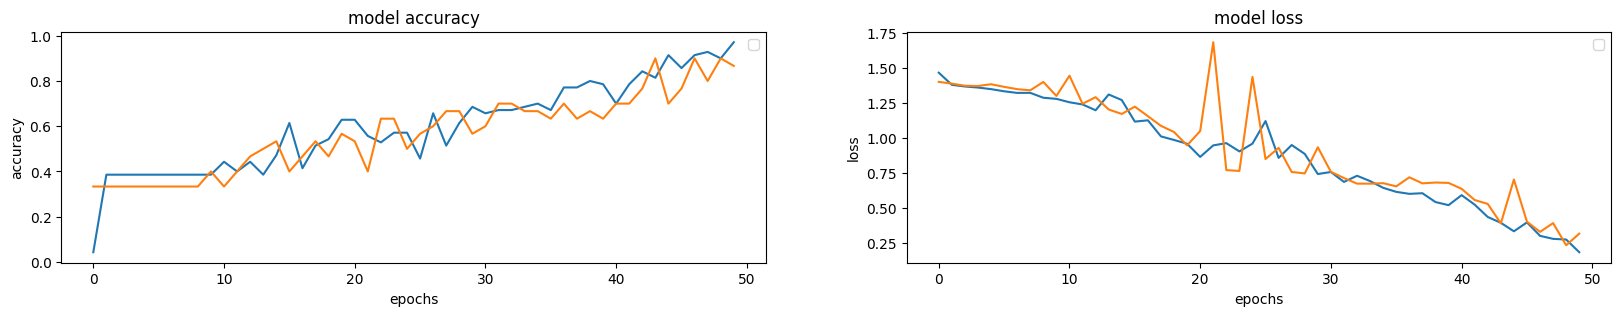

In [ ]:
fig, ax=plt.subplots(1,2,figsize=(20,3))
ax=ax.ravel()

for i, met in enumerate(['accuracy','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+ met])
    ax[i].set_title('model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend('train','val')







In [ ]:
print("Evaluate on test data:")
_, test_accuracy = Model.evaluate(x_test_adv, y_test_adv)
print("Test Accuracy:", test_accuracy)


Evaluate on test data:
1/1 [==============================] - 0s 48ms/step - loss: 0.3158 - accuracy: 0.8667
Test Accuracy: 0.8666666746139526


In [ ]:
from sklearn.metrics import classification_report


# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = np.argmax(y_test_adv, axis=1)

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=diseases_labels)

# Print classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      glioma       0.57      1.00      0.73         4
  meningioma       1.00      0.83      0.91         6
     notumor       0.91      1.00      0.95        10
   pituitary       1.00      0.70      0.82        10

    accuracy                           0.87        30
   macro avg       0.87      0.88      0.85        30
weighted avg       0.91      0.87      0.87        30



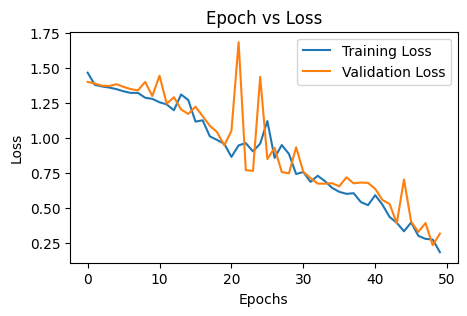

In [ ]:
# Epoch vs Loss graph
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


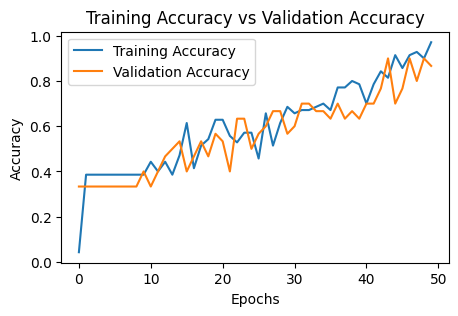

In [ ]:
# Training accuracy Vs Validation accuracy against epoch
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

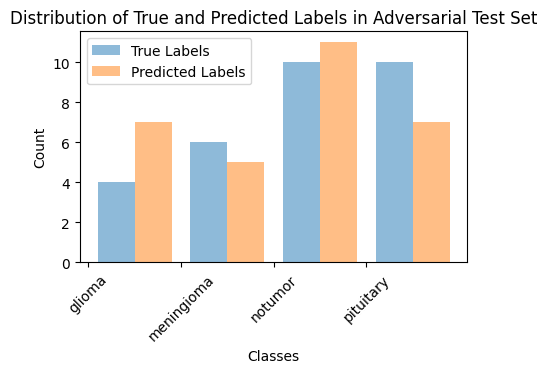

In [ ]:


plt.figure(figsize=(5, 3))
plt.hist([true_classes, predicted_classes], bins=range(len(diseases_labels) + 1), alpha=0.5, label=['True Labels', 'Predicted Labels'])
plt.xticks(np.arange(len(diseases_labels)), diseases_labels, rotation=45)
plt.title('Distribution of True and Predicted Labels in Adversarial Test Set')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.legend()
plt.show()


In [ ]:
#Test the model by real test data
#predictions2=Model.predict(test_generator)

11/11 [==============================] - 6s 501ms/step


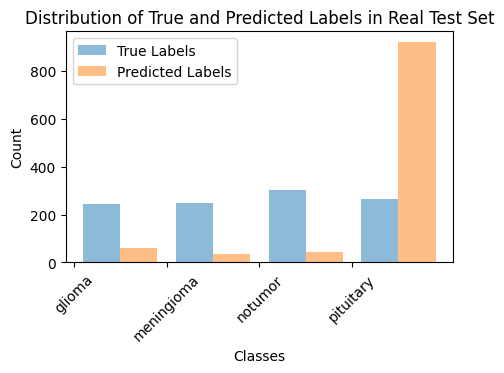

In [ ]:
'''test_labels = test_generator.classes
predicted_labels = np.argmax(predictions2, axis=1)

plt.figure(figsize=(5, 3))
plt.hist([test_labels, predicted_labels], bins=range(len(diseases_labels) + 1), alpha=0.5, label=['True Labels', 'Predicted Labels'])
plt.xticks(np.arange(len(diseases_labels)), diseases_labels, rotation=45)
plt.title('Distribution of True and Predicted Labels in Real Test Set')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.legend()
plt.show()'''


<ipython-input-81-3ae28513ab24>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')  # Get desired colormap - you can change this!


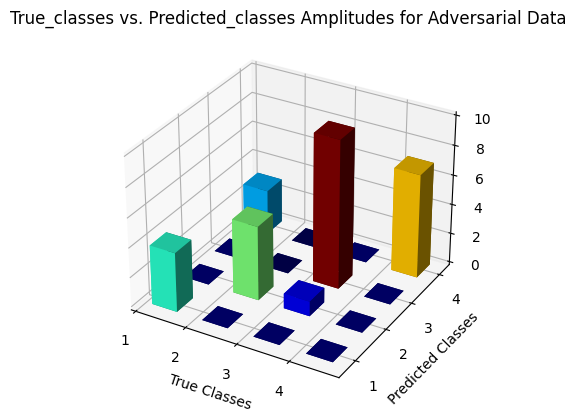

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


xAmplitudes = true_classes
yAmplitudes = predicted_classes

x = np.array(xAmplitudes)   # Turn x,y data into numpy arrays
y = np.array(yAmplitudes)

fig = plt.figure()          # Create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

# Make histogram stuff - set bins
hist, xedges, yedges = np.histogram2d(x, y, bins=(4, 4))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
dz = hist.flatten()

cmap = cm.get_cmap('jet')  # Get desired colormap - you can change this!
max_height = np.max(dz)    # Get range of colorbars so we can normalize
min_height = np.min(dz)
# Scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz]

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')

# Set labels for x and y axes
ax.set_xlabel("True Classes")
ax.set_ylabel("Predicted Classes")

ax.set_xticks([0.5, 2, 3.5, 5])
ax.set_xticklabels(['1', '2', '3', '4'])
ax.set_yticks([1.2, 2.8, 4.2, 5.8])
ax.set_yticklabels(['1', '2', '3', '4'])


plt.title("True_classes vs. Predicted_classes Amplitudes for Adversarial Data")
plt.savefig("Your_title_goes_here")
plt.show()
